In [1]:
# install low version of tensorflow for elmo (from TensorFlow Hub)
!pip uninstall tensorflow tensorflow_hub tensorflowjs
!pip install tensorflow==1.14.0 tensorflow_hub==0.5.0 tensorflowjs==1.2.6

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: tensorflow-hub 0.12.0
Uninstalling tensorflow-hub-0.12.0:
  Would remove:
    /usr/local/bin/make_image_classifier
    /usr/local/bin/make_nearest_neighbour_index
    /usr/local/lib/python3.7/dist-packages/tensorflow_hub-0.12.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow_hub/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-hub-0.12.0
     |████████████████████████████████| 10

In [2]:
import tensorflow as tf

tf.__version__

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'1.14.0'

In [3]:
import tensorflow_hub as hub

from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

from keras.models import Model
from keras.layers import Dense, Lambda, Input

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# load elmo from TensorFlow Hub
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)

In [5]:
# load dataset

urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

In [6]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
# bring first two columns (spam/ham and text)
data = data[data.columns[:2]]
data.columns = ['category', 'text']

In [8]:
# remove the duplicated data
data.drop_duplicates(subset=['text'], inplace=True) 

In [9]:
# set ham to 0 and spam to 1 - for classification
data['category'] = data['category'].replace(['ham','spam'],[0,1])

In [10]:
X_data = data['text']
y_data = data['category']

In [11]:
data.head()

,category,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
# separate dataset into two - train : test = 8 : 2
num_of_train = int(len(X_data) * 0.8)
num_of_test = int(len(X_data) - num_of_train)

In [13]:
X_train = np.asarray(X_data[:num_of_train])
X_test = np.asarray(X_data[num_of_test:])
y_train =  np.asarray(y_data[:num_of_train])
y_test = np.asarray(y_data[num_of_test:])

In [14]:
# function to translate data from keras to tensorflow & to output fits to keras
def ELMo(x): 
  return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [15]:
input = Input(shape=(1,), dtype=tf.string)
embedding_layer = Lambda(ELMo, output_shape=(1024, ))(input) # 512 dimensions each (forward + backward) ->> concatenate, 1024 dimensions
hidden_layer = Dense(256, activation='relu')(embedding_layer) # training with 256 hidden layers & activation function is relu
output = Dense(1, activation='sigmoid')(hidden_layer) 

model = Model(inputs=[input], outputs=output) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Train on 3308 samples, validate on 827 samples
Epoch 1/10
3308/3308 [==============================] - 1014s 306ms/step - loss: 0.1103 - acc: 0.9616 - val_loss: 0.0711 - val_acc: 0.9770
Epoch 2/10
3308/3308 [==============================] - 1035s 313ms/step - loss: 0.0503 - acc: 0.9846 - val_loss: 0.0472 - val_acc: 0.9843
Epoch 3/10
3308/3308 [==============================] - 978s 296ms/step - loss: 0.0615 - acc: 0.9816 - val_loss: 0.1534 - val_acc: 0.9504
Epoch 4/10
3308/3308 [==============================] - 981s 297ms/step - loss: 0.0500 - acc: 0.9840 - val_loss: 0.0398 - val_acc: 0.9879
Epoch 5/10
3308/3308 [==============================] - 979s 296ms/step - loss: 0.0264 - acc: 0.9903 - val_loss: 0.0397 - val_acc: 0.9867
Epoch 6/10
3308/3308 [==============================] - 954s 288ms/step - loss: 0.0276 - acc: 0.9909 - val_loss: 0.0630 - val_acc: 0.9794
Epoch 7/10
3308/3308 [==============================] - 981s 296ms/step - loss: 0.0251 - acc: 0.9912 - val_loss: 0.0812 - v

In [17]:
print("\n Test_accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

4135/4135 [==============================] - 1026s 248ms/step

 Test_accuracy: 0.9915


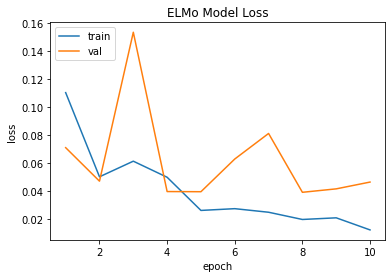

In [19]:
# draw a graph
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('ELMo Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()